In [2]:
#basic
from tqdm import tqdm
import os
from glob import glob
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 50)
import operator

#plots
import matplotlib.pyplot as plt
import seaborn as sns


#nltk
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

import re
import pickle as pkl

#gensim
from gensim.utils import lemmatize

#sklearn imports
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer

#wordcloud
from wordcloud import WordCloud,STOPWORDS

from utils import *

In [3]:
files = glob("./Story text files/*.txt")
stpwords = stopwords.words("english")
DATASET_PATH = "./Story text files/"

<h1>EDA</h1>

In [4]:
all_data_corpus_list = readFiles(files)

all_data_file_names = getFileNames(files)

all_data_len_dict = wordsPerFile(all_data_corpus_list, all_data_file_names, 
                                 isRemoveStopwords=True, stpwords=stpwords)

<h3>All Data Description</h3>
<ul>
    <li>75% of the data comes under 409 word length (without stopwords)</li>
    <li>Based on length we might not be able to find outlier in case of text but 
        removal of files having word len &lt; 5 and &gt; 2068 might help to understand data better</li>
    <li>Data is rightly skewed. Median of document word count is 186</li>
</ul>

In [5]:
values = list(all_data_len_dict.values())

print("Total files : ", len(files))
print("Min words per file: ", min(values))
print("Max words per file: ", max(values))
print("Top 10 minimum words count per document: ", sorted(list(np.unique(values)))[:10])
print("Top 10 maximum words count per document: ", sorted(list(np.unique(values)))[-10:])
print()
print("Mean words per document: %.2f "% np.mean(values))
print("Median words per document: %.2f "% np.quantile(values, .50))
print("10% data: {0}  \n25% data: {1} \n50% data: {2} \
       \n75% data: {3} \n90% data: {4}".format(np.quantile(values, .10),
                                                         np.quantile(values, .25),
                                                         np.quantile(values, .50),
                                                         np.quantile(values, .75),
                                                         np.quantile(values, .90)))
print()
print("> 95.0% is baised data: {0:0.2f} # of files {1}".format(np.quantile(values, .95), round(0.05*len(values))))
print("< 0.05% is baised data: {0:0.2f} # of files {1}".format(np.quantile(values, .05), round(0.05*len(values))))

Total files :  556
Min words per file:  0
Max words per file:  2908
Top 10 minimum words count per document:  [0, 3, 9, 13, 15, 19, 22, 23, 24, 25]
Top 10 maximum words count per document:  [1187, 1295, 1336, 1518, 1669, 1694, 1835, 1976, 2388, 2908]

Mean words per document: 310.71 
Median words per document: 186.00 
10% data: 48.0  
25% data: 97.75 
50% data: 186.0        
75% data: 409.25 
90% data: 709.0

> 95.0% is baised data: 998.25 # of files 28
< 0.05% is baised data: 32.00 # of files 28


In [7]:
#remove biased files from file list
removal_list = list(np.array(files)[np.where(np.array(values) < 32.00)[0]]) + \
               list(np.array(files)[np.where(np.array(values) > 998.25)[0]])
print(removal_list)
for rm_ele in removal_list:
    files.remove(rm_ele)
print(len(files))

['./Story text files/510.txt', './Story text files/538.txt', './Story text files/458.txt', './Story text files/499.txt', './Story text files/407.txt', './Story text files/77.txt', './Story text files/214.txt', './Story text files/217.txt', './Story text files/73.txt', './Story text files/402.txt', './Story text files/371.txt', './Story text files/5.txt', './Story text files/143.txt', './Story text files/209.txt', './Story text files/235.txt', './Story text files/97.txt', './Story text files/418.txt', './Story text files/232.txt', './Story text files/3.txt', './Story text files/225.txt', './Story text files/152.txt', './Story text files/109.txt', './Story text files/134.txt', './Story text files/254.txt', './Story text files/27.txt', './Story text files/328.txt', './Story text files/338.txt', './Story text files/339.txt', './Story text files/460.txt', './Story text files/375.txt', './Story text files/160.txt', './Story text files/389.txt', './Story text files/439.txt', './Story text fil

In [8]:
all_data_corpus_list = readFiles(files)

all_data_file_names = getFileNames(files)

all_data_len_dict = wordsPerFile(all_data_corpus_list, all_data_file_names, 
                                 isRemoveStopwords=True, stpwords=stpwords)

all_data_corpus = listToCorpus(all_data_corpus_list)

all_data_tokens = word_tokenize(all_data_corpus)

all_data_word_freq = getFrequency(all_data_tokens)

all_data_tokens_x_stpwrds = removeStopwords(all_data_corpus, stopWords=stpwords, isWordTokenize=True)

all_data_word_freq_x_stpwrds = getFrequency(all_data_tokens_x_stpwrds)



In [9]:
df_len_data = np.transpose([list(all_data_len_dict.keys()), list(all_data_len_dict.values())])
df_len_dist = pd.DataFrame(data=df_len_data, columns=["fileName", "fileCount"])
df_len_dist['fileCount'] = df_len_dist.fileCount.astype(int)
df_len_dist.head()

,fileName,fileCount
0,289.txt,302
1,504.txt,121
2,262.txt,338
3,276.txt,250
4,29.txt,112


In [10]:
new_dist = pd.cut(df_len_dist.fileCount, 10)
new_dist_dict = dict(new_dist.value_counts())

<h4>Again this shows that major document word count is under 800.</h4>

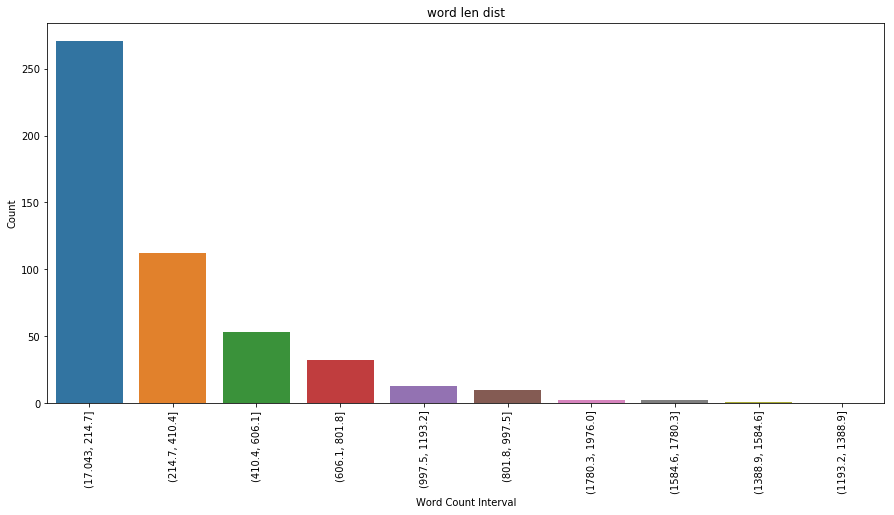

In [11]:
plt.figure(figsize=(15, 7))
sns.barplot(x=list(new_dist_dict.keys()), y=list(new_dist_dict.values()))
plt.xticks(rotation=90)
plt.xlabel("Word Count Interval")
plt.ylabel("Count")
_ = plt.title("word len dist")

<h3>Inference on word frequency (All Data)</h3>
<ul>
    <li>"the, a,and, to, of, etc" are the most dominant words in the corpus</li>
    <li>Most frequent words belongs to stop-words</li>
    <li>Total word count: <b>328989</b></li>
    <li>Total word count without stopword: <b>172752</b></li>
    <li>Stopword percent: 52.5%</li>
</ul>
<h4>As stopword % is above 50. Removal of stopwords will help in better modeling</h4>

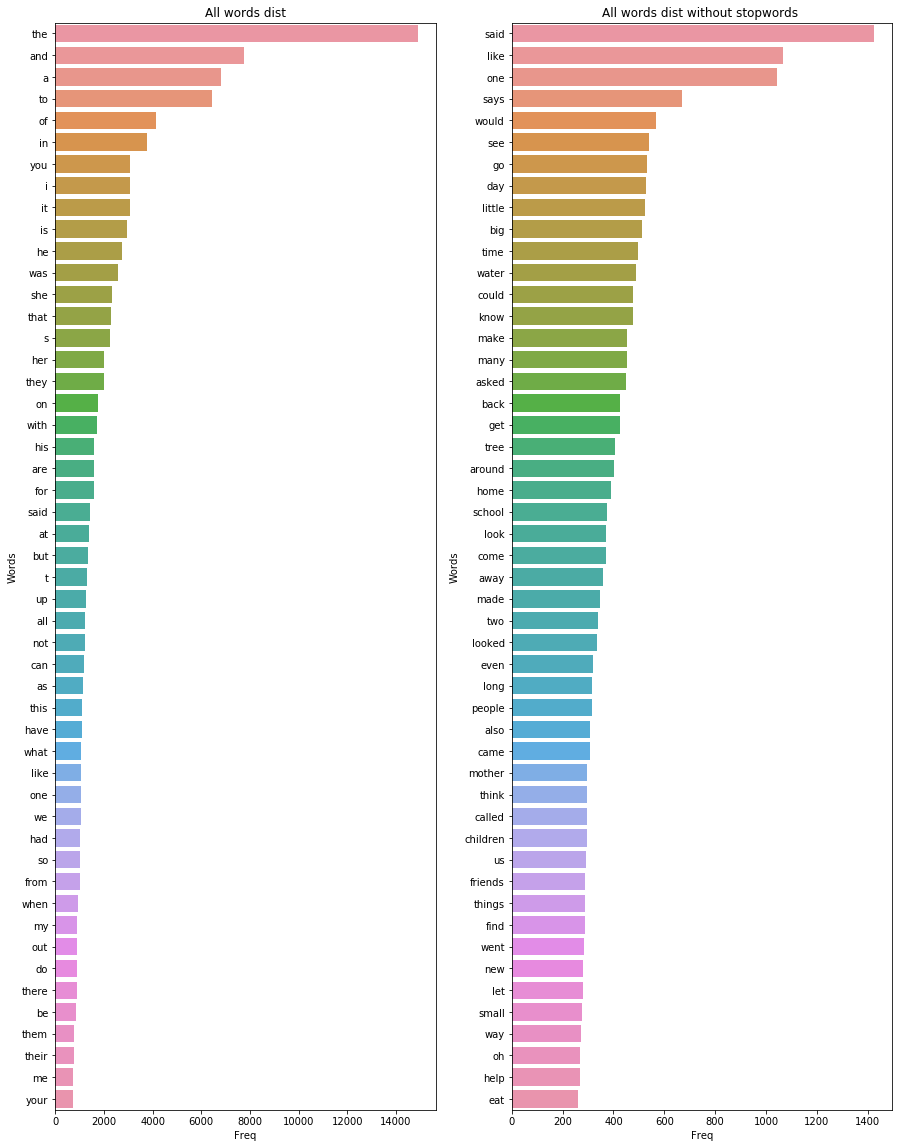

In [12]:
all_data_titles = ["All words dist", "All words dist without stopwords "]
plt.figure(figsize=(15,20))
for idx, word_freq in enumerate([all_data_word_freq, all_data_word_freq_x_stpwrds]):
    plt.subplot(1,2,idx+1)
    sns.barplot(x=list(word_freq.values())[:50], y = list(word_freq.keys())[:50])
    plt.xlabel("Freq")
    plt.ylabel("Words")
    plt.title(all_data_titles[idx])

<h4>Data analysis by taking three random sample of size 50, where each sample will help us to understand the
    distribution of data</h4>

In [13]:
sample_files_1 = shuffle(files, n_samples = 50, random_state = 2020)
sample_files_2 = shuffle(files, n_samples = 50, random_state = 2040)
sample_files_3 = shuffle(files, n_samples = 50, random_state = 1231)

In [14]:
sample_files_1_names = getFileNames(sample_files_1)
sample_files_2_names = getFileNames(sample_files_2)
sample_files_3_names = getFileNames(sample_files_3)

In [15]:
sample_1_corpus_list = readFiles(sample_files_1)
sample_2_corpus_list = readFiles(sample_files_2)
sample_3_corpus_list = readFiles(sample_files_3)

In [16]:
sample_1_corpus = listToCorpus(sample_1_corpus_list)
sample_2_corpus = listToCorpus(sample_2_corpus_list)
sample_3_corpus = listToCorpus(sample_3_corpus_list)

In [17]:
sample_1_tokens = word_tokenize(sample_1_corpus)
sample_2_tokens = word_tokenize(sample_2_corpus)
sample_3_tokens = word_tokenize(sample_3_corpus)

<h4>Sorted word frequency dict for all three sample</h4>

In [18]:
sample_1_word_freq = getFrequency(sample_1_tokens)
sample_2_word_freq = getFrequency(sample_2_tokens)
sample_3_word_freq = getFrequency(sample_3_tokens)

<h3>Inference on word frequency based on Sample</h3>
<ul>
    <li>"the, a,and, to, of, etc" are the most dominant words in the corpus</li>
    <li>All the samples are having stopword dominancy</li>
</ul>
<h4>As we can see all the samples are having stopword dominancy. It can create problem in making n-gram.
    Removal of stopword is better option.</h4>

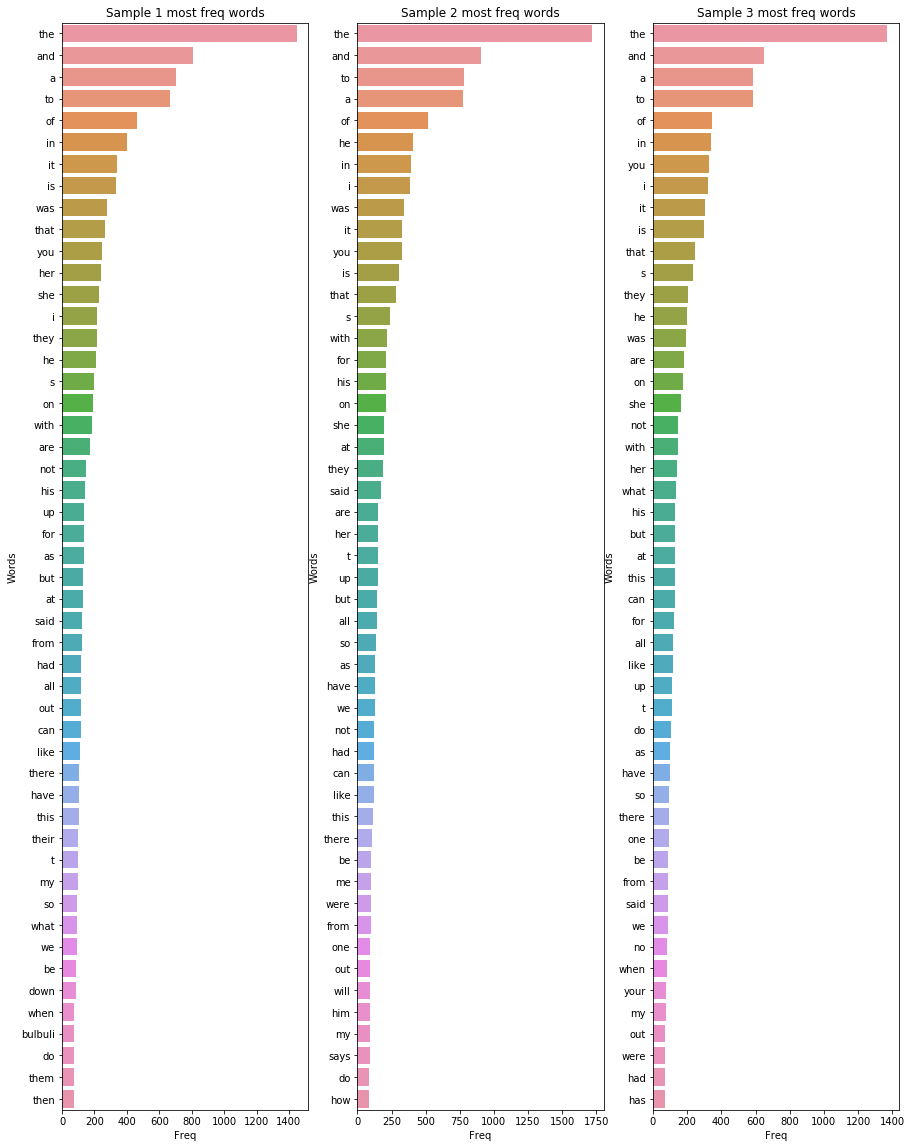

In [19]:
plt.figure(figsize=(15,20))
for idx, word_freq in enumerate([sample_1_word_freq, sample_2_word_freq, sample_3_word_freq]):
    plt.subplot(1,3,idx+1)
    sns.barplot(x=list(word_freq.values())[:50], y = list(word_freq.keys())[:50])
    plt.xlabel("Freq")
    plt.ylabel("Words")
    plt.title("Sample "+str(idx+1)+" most freq words")

<h3>Removal of stopwords</h3>

In [20]:
sample_1_tokens_x_stpwrds = removeStopwords(sample_1_tokens, stopWords=stpwords)
sample_2_tokens_x_stpwrds = removeStopwords(sample_2_tokens, stopWords=stpwords)
sample_3_tokens_x_stpwrds = removeStopwords(sample_3_tokens, stopWords=stpwords)

<h3>As compare to over all corpus stopwords in samples are less.</h3>

In [21]:
print("% of stopwords in sample 1: ",(len(sample_1_tokens) - len(sample_1_tokens_x_stpwrds))/len(sample_1_tokens))
print("% of stopwords in sample 2: ",(len(sample_2_tokens) - len(sample_2_tokens_x_stpwrds))/len(sample_2_tokens))
print("% of stopwords in sample 3: ",(len(sample_3_tokens) - len(sample_3_tokens_x_stpwrds))/len(sample_3_tokens))

% of stopwords in sample 1:  0.4771105826397146
% of stopwords in sample 2:  0.46942644967609415
% of stopwords in sample 3:  0.4718672590728581


In [22]:
sample_1_word_freq_x_stpwrds = getFrequency(sample_1_tokens_x_stpwrds)
sample_2_word_freq_x_stpwrds = getFrequency(sample_2_tokens_x_stpwrds)
sample_3_word_freq_x_stpwrds = getFrequency(sample_3_tokens_x_stpwrds)

<h3>Now, top 4 dominant words are "said, like, one, says" which is okay to have in data. <br>Word distribution in samples are much better after removal of stopwords</h3>

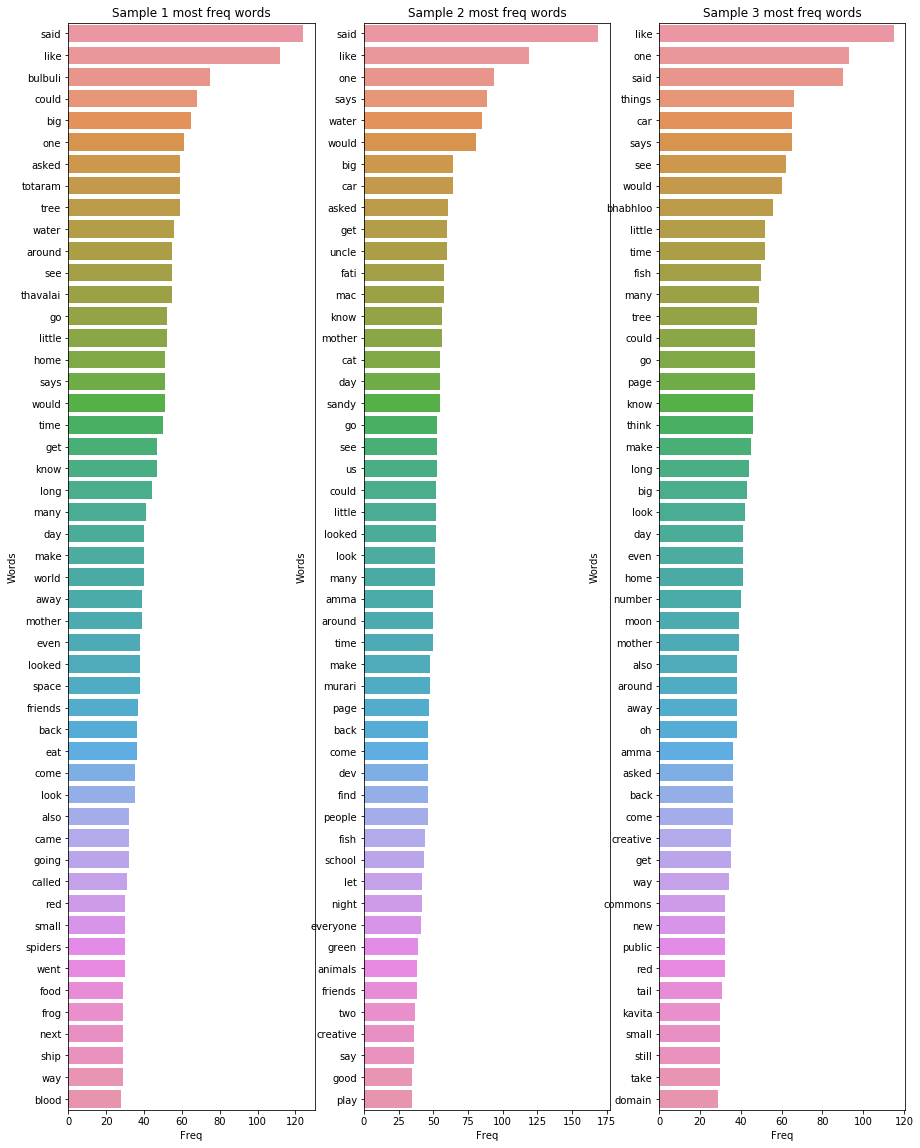

In [23]:
plt.figure(figsize=(15,20))
for idx, word_freq in enumerate([sample_1_word_freq_x_stpwrds, 
                                 sample_2_word_freq_x_stpwrds, 
                                 sample_3_word_freq_x_stpwrds]):
    plt.subplot(1,3,idx+1)
    sns.barplot(x=list(word_freq.values())[:50], y = list(word_freq.keys())[:50])
    plt.xlabel("Freq")
    plt.ylabel("Words")
    plt.title("Sample "+str(idx+1)+" most freq words")

In [24]:
sample_1_tokens_lemma = lemmatizeCorpus(sample_1_corpus, isListOfDocs = False)
sample_2_tokens_lemma = lemmatizeCorpus(sample_2_corpus, isListOfDocs = False)
sample_3_tokens_lemma = lemmatizeCorpus(sample_3_corpus, isListOfDocs = False)

<h3>
    <ul>
        <li>Word Cloud representation of lemmitized corpus for visual understanding of word frequency.</li>
        <li>Lemmitization can help in better understanding of words but can reduce effect of diffculty weights.</li>
            <li>After lemmitization "like, one, said" are not dominant but "Say" is still most dominant word in the sample corpus.</li>
    </ul>
</h3>


Word Cloud of Sample 1 


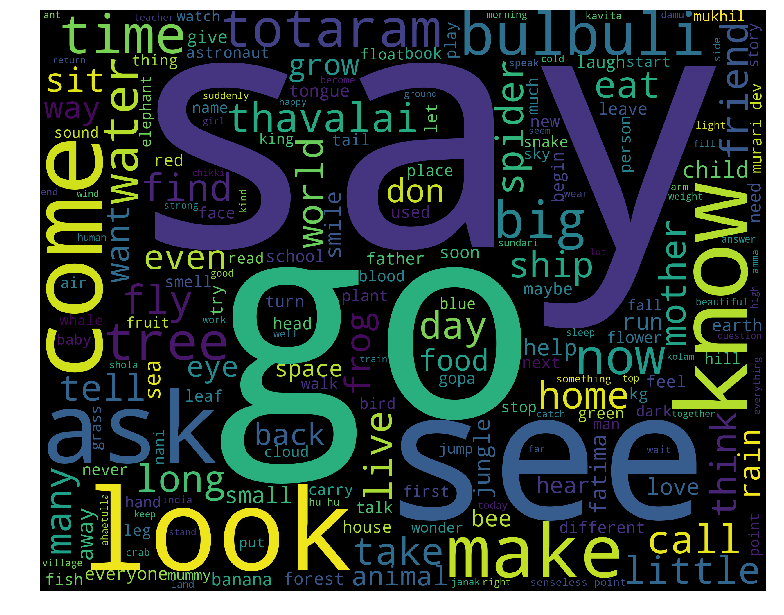

Word Cloud of Sample 2 


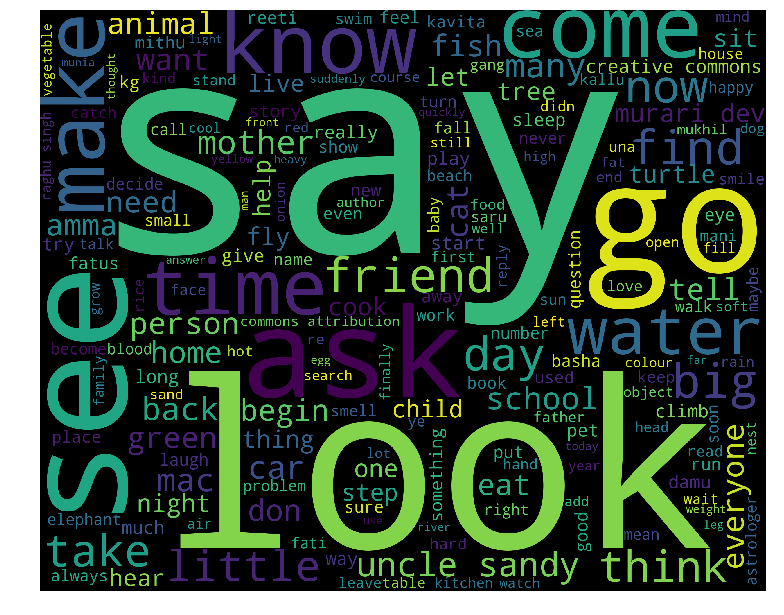

Word Cloud of Sample 3 


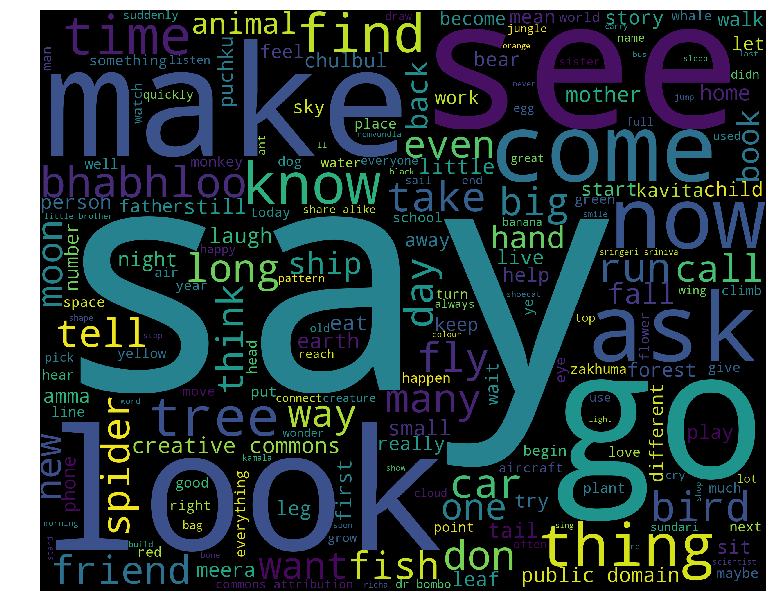

In [25]:
print("Word Cloud of Sample 1 ")
plotWordCloud(" ".join(sample_1_tokens_lemma))
print("Word Cloud of Sample 2 ")
plotWordCloud(" ".join(sample_2_tokens_lemma))
print("Word Cloud of Sample 3 ")
plotWordCloud(" ".join(sample_3_tokens_lemma))

In [26]:
sample_1_tokens_lemma = lemmatizeCorpus(sample_1_corpus_list, isListOfDocs = True)
sample_2_tokens_lemma = lemmatizeCorpus(sample_2_corpus_list, isListOfDocs = True)
sample_3_tokens_lemma = lemmatizeCorpus(sample_3_corpus_list, isListOfDocs = True)

In [27]:
sample_1_vectorizer = TfidfVectorizer(ngram_range=(1,3), max_features=10000)
sample_2_vectorizer = TfidfVectorizer(ngram_range=(1,3), max_features=10000)
sample_3_vectorizer = TfidfVectorizer(ngram_range=(1,3), max_features=10000)

In [28]:
sample_1_features = sample_1_vectorizer.fit_transform(allToString(sample_1_tokens_lemma,
                                                                  isListOfDocs=True)).toarray()
sample_1_feature_names = sample_1_vectorizer.get_feature_names()

sample_2_features = sample_2_vectorizer.fit_transform(allToString(sample_2_tokens_lemma,
                                                                  isListOfDocs=True)).toarray()
sample_2_feature_names = sample_2_vectorizer.get_feature_names()

sample_3_features = sample_3_vectorizer.fit_transform(allToString(sample_3_tokens_lemma,
                                                                  isListOfDocs=True)).toarray()
sample_3_feature_names = sample_3_vectorizer.get_feature_names()

<h3>Distance Matrix Inference</h3>
<ul>
    <li>Features extracted using TF-IDF with n-gram range(1,3)</li>
    <li>Calculated "Euclidean Distance" between all the sample feature to find the closeness of documents</li>
    <li>Found dublicate documents with minimal changes</li>
</ul>

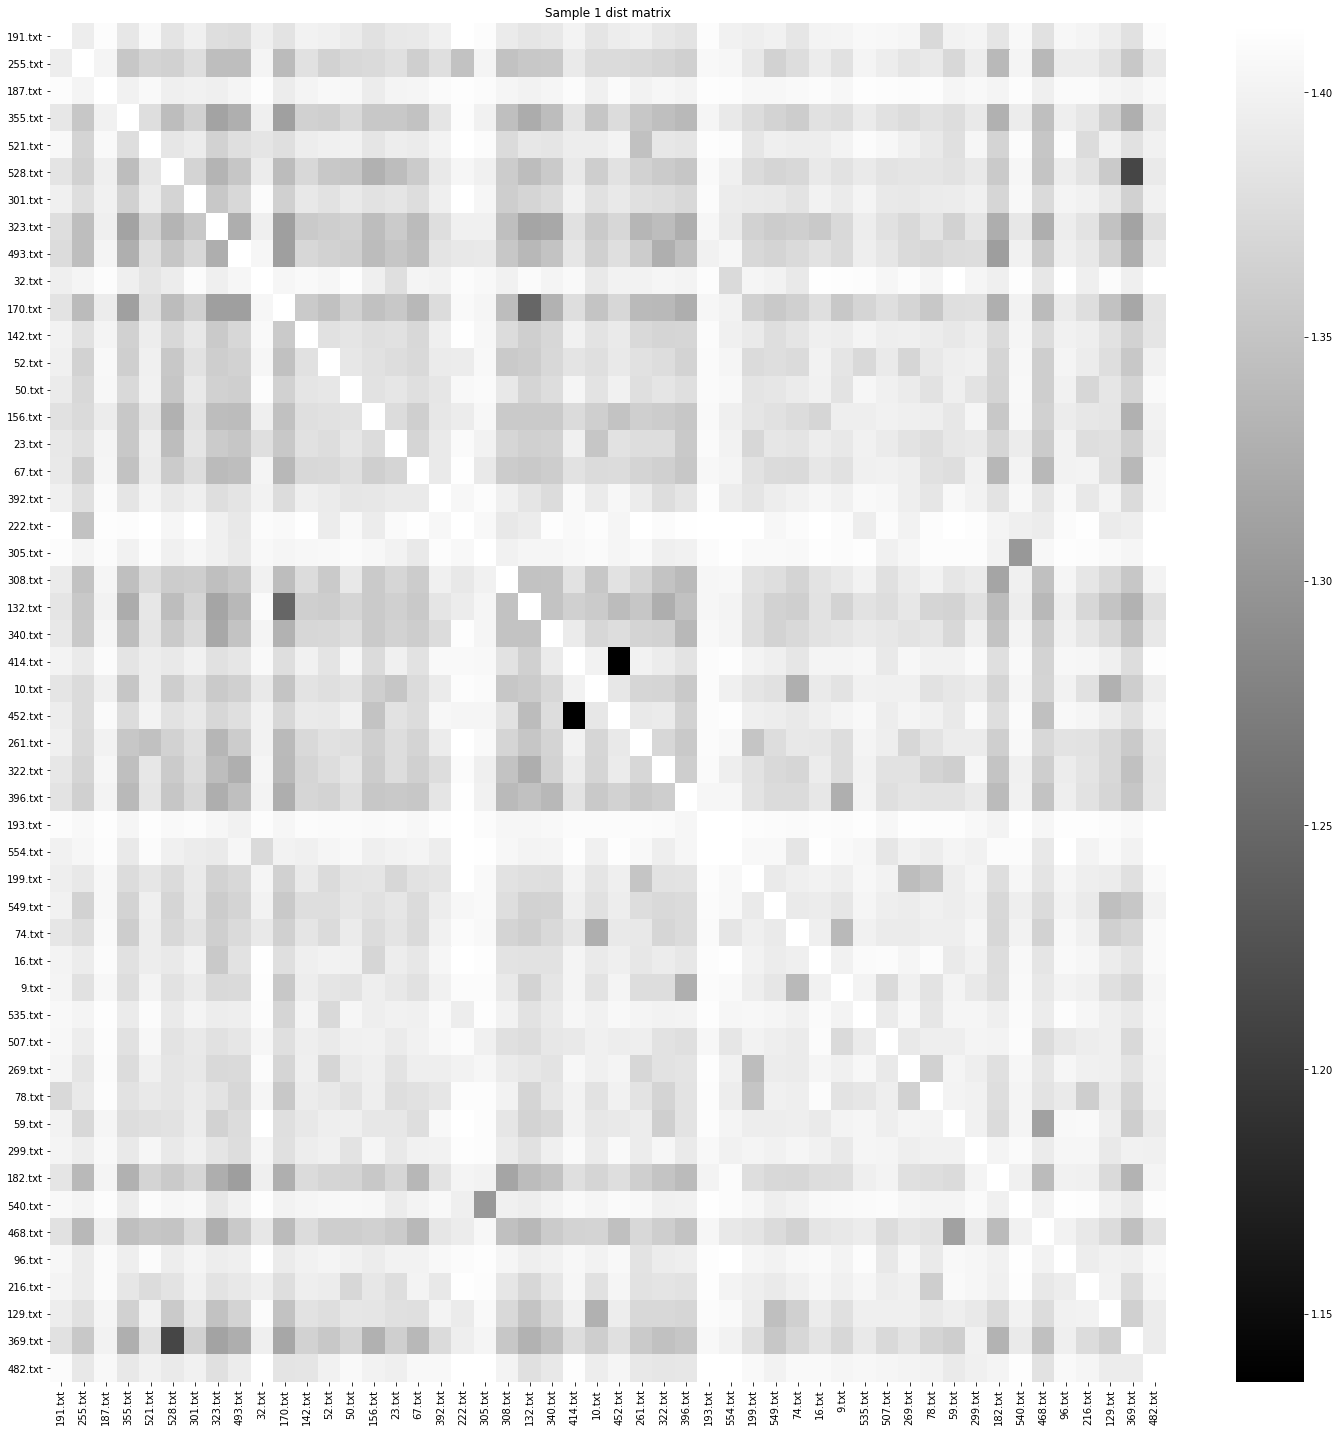

In [29]:
sample_1_feature_matrix, _ = createDistMatrix(sample_1_features, sample_files_1_names, 
                                              visualize=True, figsize=(25,25), title="Sample 1 dist matrix")

<h3>Dublicate documents</h3>

In [32]:
readFiles(["./Story text files/305.txt","./Story text files/85.txt"], isRemoveSpecailchar=False, isToLower=False)

["['Pehelwaan ji!He drinks ten litres of milk everyday.He eats fifty rotis.He lifts weights of a hundred kilos.He walks with a swagger.He orders all the children about.One day, Gappu said, “Will you wrestle with me?”Pehelwaan ji laughed. And then agreed.Both of them slapped their thighs!Pehelwaan ji caught hold of Gappu.Gappu tickled him in the stomach.Hee…Heee…Heeee… Pehelwaan ji jumped!As Gappu tickled him, Pehelwaan ji began to dance.Ha…Ha…Hee…Hee…Hoo…Hoo… Pehelwaan ji rolled about helplessly. And he ran away.The kids are not scared of him any more. He is scared of them.']",
 "['Pehelwaan ji!He drinks ten litres of milk everyday.He eats fifty rotis.He lifts weights of a hundred kilos.He walks with a swagger.He orders all the children about.One day, Gappu said, “Will you wrestle with me?”Pehelwaan ji laughed. And then agreed.Both of them slapped their thighs!Pehelwaan ji caught hold of Gappu.Gappu tickled him in the stomach.Hee…Heee…Heeee… Pehelwaan ji jumped!As Gappu tickled him, Pe

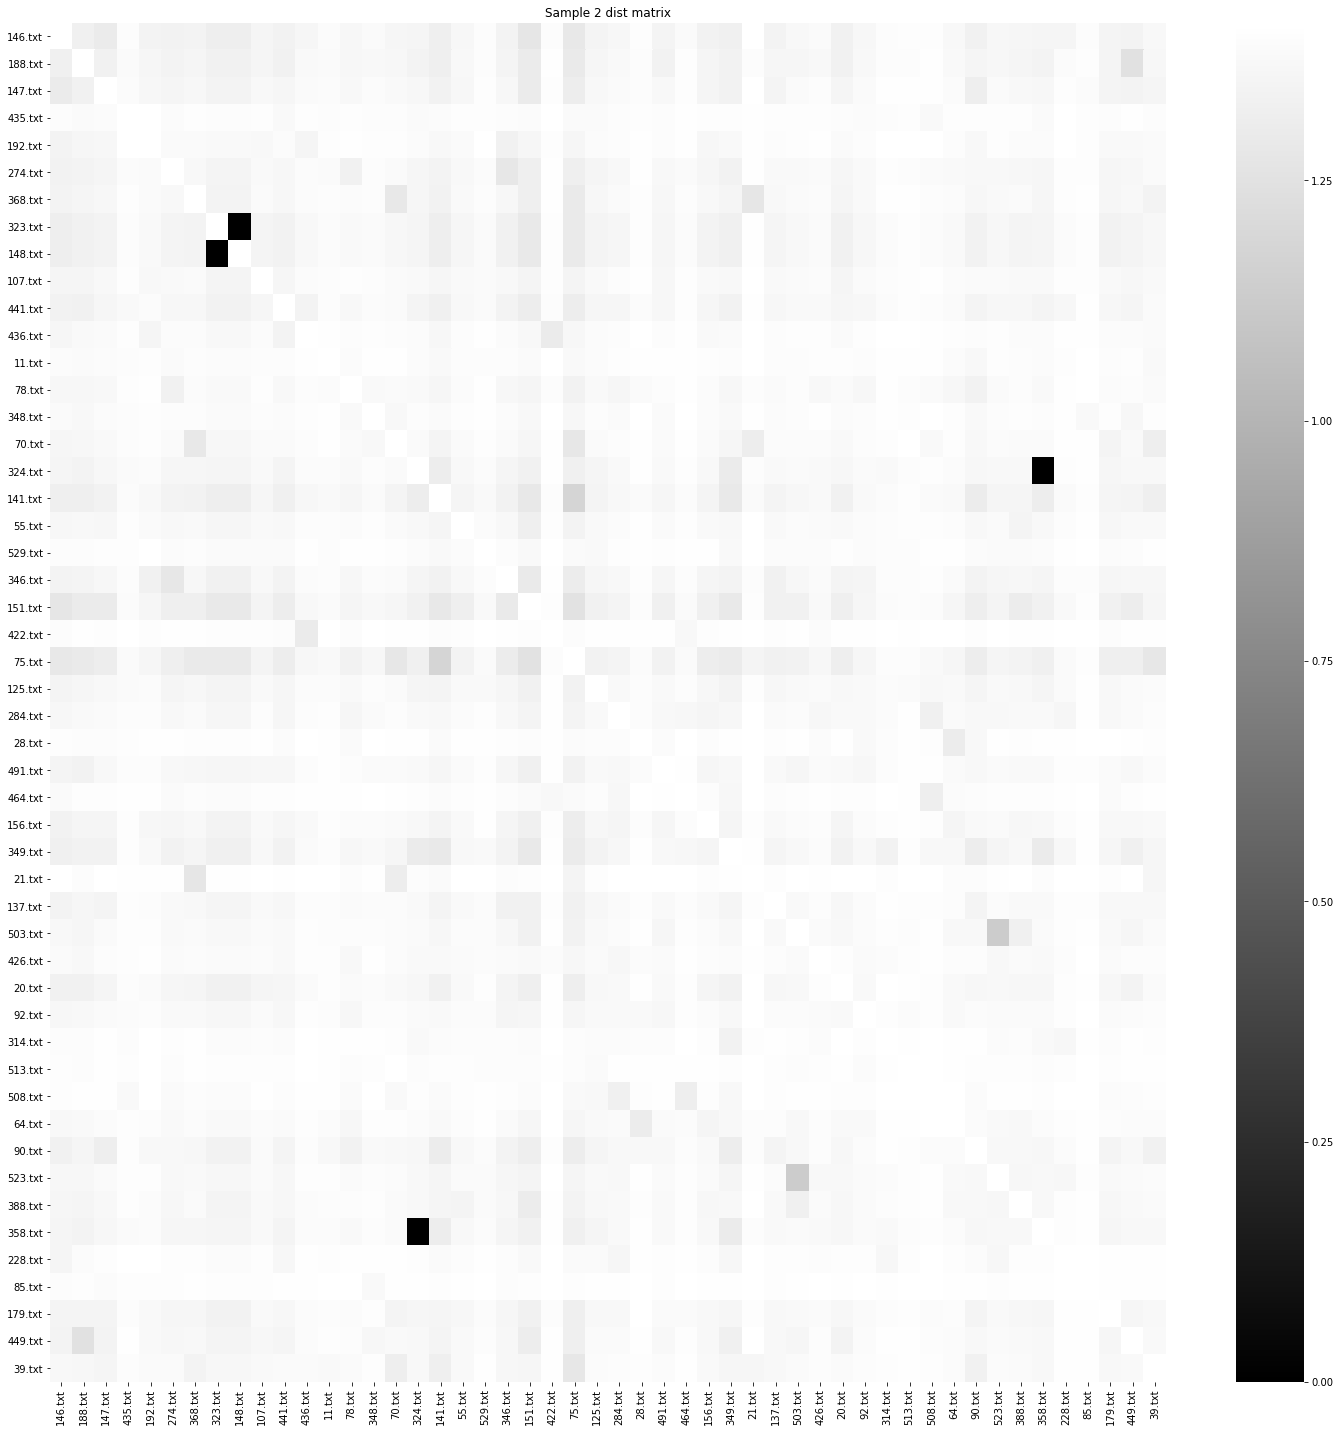

In [33]:
sample_2_feature_matrix, _ = createDistMatrix(sample_2_features, sample_files_2_names,
                                              visualize=True, figsize=(25,25), title="Sample 2 dist matrix")

In [35]:
#To see dublicate docs uncomment the code

# readFiles(["./Story text files/148.txt","./Story text files/323.txt"], isRemoveSpecailchar=False, isToLower=False)

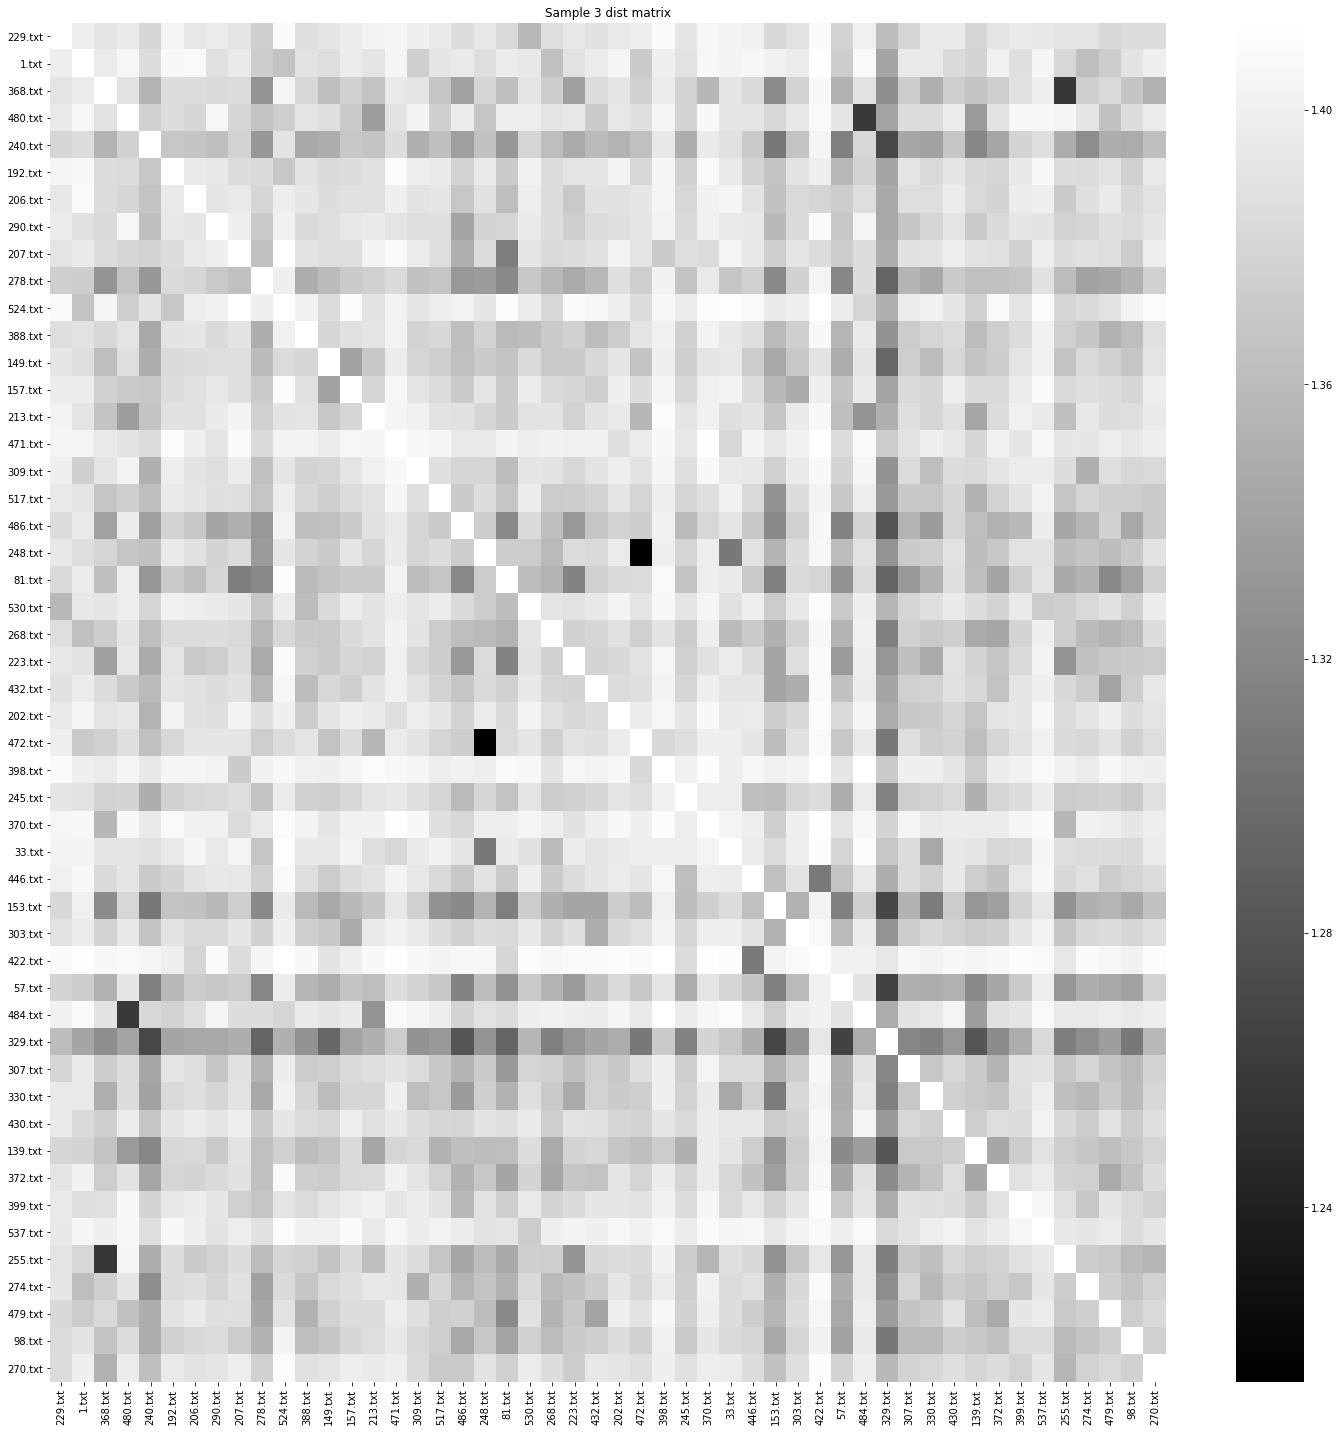

In [36]:
sample_3_feature_matrix, _ = createDistMatrix(sample_3_features, sample_files_3_names,
                                              visualize=True, figsize=(25,25), title="Sample 3 dist matrix")

In [37]:
#To see dublicate docs uncomment the code

# readFiles(["./Story text files/141.txt","./Story text files/53.txt"], isRemoveSpecailchar=False, isToLower=False)

<h1>Cleaning</h1>

<h3>Find Dublicates in all data</h3>
<ul>
    <li>There are 68 exact dublicate pairs found</li>
    <li>There might be some most close document which also can be considered to be dublicates but as of now we are only looking for exact dublicates</li>
</ul>

In [67]:
all_data_tokens_lemma = lemmatizeCorpus(all_data_corpus_list, isListOfDocs = True)
all_data_vectorizer = TfidfVectorizer(ngram_range=(1,3), max_features=10000)
all_data_features = all_data_vectorizer.fit_transform(allToString(all_data_tokens_lemma,
                                                                  isListOfDocs=True)).toarray()
all_data_feature_matrix, _ = createDistMatrix(all_data_features, all_data_file_names, visualize=False)

In [68]:

dublicate_files = []
for outer_idx, mat in enumerate(all_data_feature_matrix):
    for inner_idx, v in enumerate(mat):
        if (v <= 0.25) & (outer_idx != inner_idx):
            dublicate_files.append([DATASET_PATH+all_data_file_names[outer_idx], DATASET_PATH+all_data_file_names[inner_idx]])

<h3>Sample dublicate files </h3>

In [69]:
len(dublicate_files)

124

In [70]:
readFiles(["./Story text files/100.txt","./Story text files/299.txt"], isRemoveSpecailchar=False, isToLower=False)

['[\'Have you met my Aaji? Everyone says that my Aaji has a tail.Mumma says it even does a pirouette, when Aaji sings my favourite song. Aaji’s tail follows her all day long, I wonder why I haven\\\'t seen the tail yet?Papa says the tail is growing long and strong. The tail even answers Aaji\\\'s phone, when she gets a call. What! Why haven\\\'t I seen the tail yet?My teacher says the tail helps Aaji a lot. The tail even helps water the plants in the pots. Sigh! Why haven’t I seen the tail yet?The bus driver says the tail sits next to Aaji in the bus. The tail imitates everything that she does. Someone please tell me, why haven\\\'t I seen the tail yet?One day I asked Aaji, "Everybody says that you have a tail. But why haven\\\'t I seen the tail yet? "Aaji laughed out loud. She pulled out her phone. Look! It\\\'s me. And that\\\'s me, it\\\'s me again. It\\\'s me everywhere!Now I know why everyone says that my Aaji has a tail. Because it was always me following Aaji on her small and bi

In [71]:
readFiles(["./Story text files/203.txt","./Story text files/499.txt"], isRemoveSpecailchar=False, isToLower=False)

["['Why are wheels round?This bus does not move.Why are bangles round?I will not buy square bangles.Why is a chapati round?It is not round when I try to roll it.Why is your bindi round?Do you think this bindi looks nice?Why are eyes round?They are round and they are BIG!Why is zero round? I don’t know.']",
 "['Why are wheels round?This bus does not move.Why are bangles round?I will not buy square bangles.Why is a chapati round?It is not round when I try to roll it.Why is your bindi round?Do you think this bindi looks nice?Why are eyes round?They are round and they are BIG!Why is zero round? I don’t know.']"]

In [72]:
readFiles(["./Story text files/227.txt","./Story text files/99.txt"], isRemoveSpecailchar=False, isToLower=False)

['["I have a friend. She lives in my house.When I am happy, so is she.When I cry, she cries too.But I cannot hear her voice. My friend lives inside the mirror.“Come out,” I tell her, “we will play.” She does not come out.I am not happy. I go to sleep.She comes out of the mirror in my sleep! And we have fun.We play, we run, we shout and scream together.When I talk to her, she also talks to me.In the morning, my friend will go back into the mirror.But I don\'t mind at all. We will play again in my dreams!"]',
 '["I have a friend. She lives in my house.When I am happy, so is she.When I cry, she cries too.But I cannot hear her voice. My friend lives inside the mirror.“Come out,” I tell her, “we will play.” She does not come out.I am not happy. I go to sleep.She comes out of the mirror in my sleep! And we have fun.We play, we run, we shout and scream together.When I talk to her, she also talks to me.In the morning, my friend will go back into the mirror.But I don\'t mind at all. We will pla

In [73]:
#remove Dublicates and save the file names
unique_pairs = {tuple(sorted(p)) for p in dublicate_files}
remove_dublicates = np.unique([val[1] for val in list(unique_pairs)])
print(len(remove_dublicates))
unique_file_names = files.copy()

for name in remove_dublicates:
    unique_file_names.remove(name)

58


<h3>Cleaned Files: 438 <br> Save unique_file_names</h3>

In [74]:
len(unique_file_names)

438

In [62]:
with open("unique_file_names.pkl", "wb") as fp:
    pkl.dump(unique_file_names, fp)

In [44]:
# with open("unique_file_names.pkl", "rb") as fp:
#     unique_file_names = pkl.load(fp)